# Distance along CC path
setting "0" as centre of the the Northern CCS, negative upstream, and positive downstream

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
from pyproj import Geod
from shapely.ops import unary_union
from cartopy.io.shapereader import natural_earth, Reader
from shapely.geometry import Point, MultiPoint, GeometryCollection, LineString
from shapely.ops import unary_union
from cartopy.feature import NaturalEarthFeature
from shapely.geometry import (
    Point, MultiPoint, LineString, MultiLineString, GeometryCollection
)

import warnings
warnings.filterwarnings("ignore")

# Functions

In [41]:
def isobath_lon(lat):
    """
    Return the easternmost longitude of the 2000 m isobath at this latitude.
    Handles Point, MultiPoint, LineString, MultiLineString, and GeometryCollection.
    """
    # build a horizontal scan line across your plotting lon‐range
    scan = LineString([ (xlim[0], lat), (xlim[1], lat) ])
    result = iso2k.intersection(scan)

    # collect candidate points
    pts = []
    if isinstance(result, Point):
        pts = [result]
    elif isinstance(result, MultiPoint):
        pts = list(result.geoms)
    elif isinstance(result, LineString):
        # take both end‐points of the overlap segment
        pts = [Point(c) for c in result.coords]
    elif isinstance(result, MultiLineString):
        # flatten all the segment end‐points
        for seg in result.geoms:
            pts.extend(Point(c) for c in seg.coords)
    elif isinstance(result, GeometryCollection):
        for geom in result.geoms:
            if isinstance(geom, Point):
                pts.append(geom)
            elif isinstance(geom, LineString):
                pts.extend(Point(c) for c in geom.coords)
            elif isinstance(geom, MultiLineString):
                for seg in geom.geoms:
                    pts.extend(Point(c) for c in seg.coords)
    else:
        raise RuntimeError(f"Unexpected intersection type: {type(result)}")

    # filter to the Pacific shelf‐break window and pick the easternmost
    pts = [p for p in pts if -140 < p.x < -115]
    if not pts:
        raise ValueError(f"No 2 000 m isobath found at lat={lat}")
    return max(p.x for p in pts)


def along_track_distance_array(lon_pts, lat_pts):
    """
    Compute signed along-track distances (in km) to both the NS and EW tracks
    for arrays of input points. EW distances are NaN outside of [46.5, 50.5]°N.

    Parameters
    ----------
    lon_pts, lat_pts : array-like
        Arrays of input longitude and latitude points.

    Defined earlier in code
    -----------------------
    lons_NS, lats_NS, d_NS : array-like
        North-south track coordinates and distances.
    lons_EW, lats_EW, d_EW : array-like
        East-west track coordinates and distances.
    geod : pyproj.Geod
        Geodetic calculator.

    Returns
    -------
    d_NS_out : np.ndarray
        Along-track distances (km) to NS track.
    d_EW_out : np.ndarray
        Along-track distances (km) to EW track, NaN outside 46.5–50.5°N.
    """
    lon_pts = np.asarray(lon_pts)
    lat_pts = np.asarray(lat_pts)

    d_NS_out = np.empty_like(lon_pts, dtype=float)
    d_EW_out = np.empty_like(lon_pts, dtype=float)

    ns_max_distance_km = 600
    for i, (lon, lat) in enumerate(zip(lon_pts, lat_pts)):
        # --- NS distance ---
        _, _, dist_NS = geod.inv(
            lons_NS, lats_NS,
            np.full_like(lons_NS, lon),
            np.full_like(lats_NS, lat)
        )
        idx_NS = np.argmin(dist_NS)
        if dist_NS[idx_NS] <= ns_max_distance_km*1000:
            d_NS_out[i] = d_NS[idx_NS]
        else:
            d_NS_out[i] = np.nan

        # --- EW distance ---
        if 46.5 <= lat <= 50.5:
            _, _, dist_EW = geod.inv(
                lons_EW, lats_EW,
                np.full_like(lons_EW, lon),
                np.full_like(lats_EW, lat)
            )
            idx_EW = np.argmin(dist_EW)
            d_EW_out[i] = d_EW[idx_EW]
        else:
            d_EW_out[i] = np.nan

    return d_NS_out, d_EW_out

def map_line(df, ax,ticklabels=True, lw=2,mark='o'):
    lats_NS, lons_NS, d_NS = df.latNS, df.lonNS, df.distNS
    lats_EW, lons_EW, d_EW = df.latEW, df.lonEW, df.distEW

    ax.plot(lons_NS, lats_NS, '-', transform=crs.PlateCarree(), color='k', lw=lw,zorder=4)
    ax.plot(lons_EW, lats_EW, '--', transform=crs.PlateCarree(), color='k', lw=lw,zorder=4)

    # — place tick-marks every ±1000 km —
    ticks = [-1000, -500, 0, 500,1000, 1500,2000,2500]
    for t in ticks:
        # Draw tick on NS leg if in range
        if d_NS.min() <= t <= d_NS.max():
            idx = np.argmin(np.abs(d_NS - t))
            lon_t, lat_t = lons_NS[idx], lats_NS[idx]
            ax.plot([lon_t], [lat_t], marker=mark, markersize=4,
                    transform=crs.PlateCarree(), color='k')

        # Draw tick on EW leg if in range
        if d_EW.min() <= t <= d_EW.max():
            idx = np.argmin(np.abs(d_EW - t))
            lon_t, lat_t = lons_EW[idx], lats_EW[idx]
            ax.plot([lon_t], [lat_t], marker=mark, markersize=4,
                    transform=crs.PlateCarree(), color='k')
            
    if ticklabels == True:
        for t in ticks[1::2]:
            if d_NS.min() <= t <= d_NS.max():
                idx = np.argmin(np.abs(d_NS - t))
                lon_t, lat_t = lons_NS[idx], lats_NS[idx]
                ax.text(lon_t-0.5, lat_t, f"{int(t):+d}",
                        transform=crs.PlateCarree(),
                        va='bottom', ha='right', fontsize=8, zorder=6)

            if d_EW.min() <= t <= d_EW.max():
                idx = np.argmin(np.abs(d_EW - t))
                lon_t, lat_t = lons_EW[idx], lats_EW[idx]
                ax.text(lon_t, lat_t+0.02, f"{int(t):+d}",
                        transform=crs.PlateCarree(),
                        va='bottom', ha='right', fontsize=8, zorder=6)

# Path Line

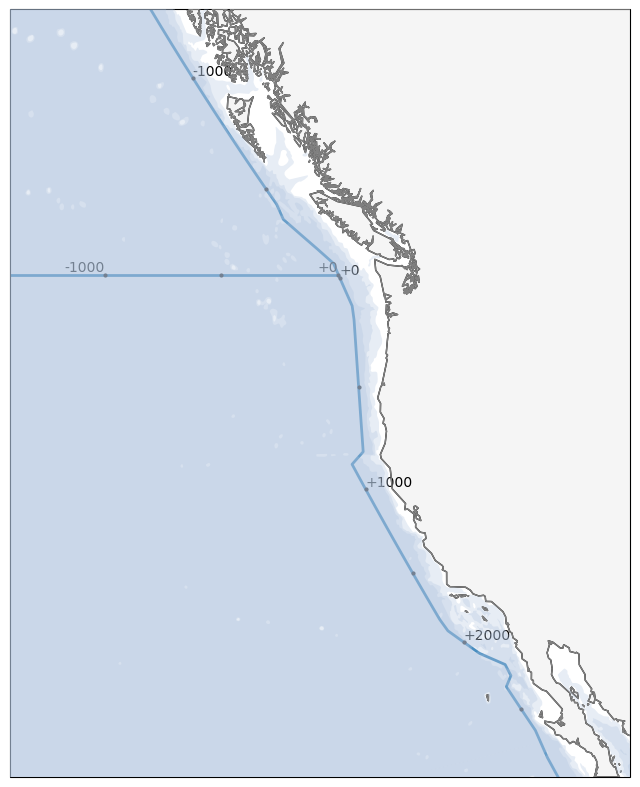

In [61]:
ylim = [25,57]
xlim = [-145.5,-110.2]
fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('low', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('low', edgecolor='grey', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3, zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='lightsteelblue',alpha=0.3,zorder=4))

# … coastline & bathymetry here …

# — PARAMETERS —
pivot_lat = 47.8             # switch-over latitude
offset_m = 50e3             # 100 km offshore
tick_km = 1000               # label every 2000 km
leg_samps = 60             # how many points along each leg

# geodesic helper
geod = Geod(ellps='WGS84')

# grab the 2 000 m isobath as a Shapely geometry
iso2k_feature = NaturalEarthFeature(
    category='physical',
    name='bathymetry_I_2000',
    scale='10m',
)
iso2k = unary_union(list(iso2k_feature.geometries()))
iso2k = iso2k.simplify(tolerance=0.8, preserve_topology=True)

# — 1) build the NS (coast-following) leg: from 57°N to 25°N —
lats_NS = np.linspace(58.1, 27.4, leg_samps-3)
lons_NS_coast = np.array([isobath_lon(lat) for lat in lats_NS])
lats_NS = np.append(lats_NS,np.array([26,25.5,25]))
lons_NS_coast = np.append(lons_NS_coast,np.array([-114.4,-114.1,-113.8]))

# offset each point 50 km offshore (az=270°)
azs_NS = np.full_like(lons_NS_coast, 270.0)
lons_NS, lats_NS, _ = geod.fwd(lons_NS_coast, lats_NS, azs_NS, np.full(leg_samps, offset_m))

# compute cumulative distances along NS leg (pivot at 48.5N)
_, _, segd_NS = geod.inv(lons_NS[:-1], lats_NS[:-1], lons_NS[1:], lats_NS[1:])
d_NS = np.concatenate([[0], np.cumsum(segd_NS)])/1000

# set 48.5°N as 0 km reference
idx_pivot_NS = np.argmin(np.abs(lats_NS - pivot_lat))
d_NS = d_NS - d_NS[idx_pivot_NS]

# — 2) build the EW leg along pivot_lat (westward from pivot point) —
pivot_lon_coast = isobath_lon(pivot_lat)
pivot_lon_off, pivot_lat_off, _ = geod.fwd(pivot_lon_coast, pivot_lat, 270, offset_m)

lons_EW = np.linspace(pivot_lon_off, xlim[0], leg_samps)
lats_EW = np.full_like(lons_EW, pivot_lat_off)

# compute distances from pivot (negative westward)
_, _, segd_EW = geod.inv(lons_EW[:-1], lats_EW[:-1], lons_EW[1:], lats_EW[1:])
d_EW = -np.concatenate([[0], np.cumsum(segd_EW)])/1000

# — 3) plot both legs —
ax.plot(lons_NS, lats_NS, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)
ax.plot(lons_EW, lats_EW, '-', transform=crs.PlateCarree(), color='tab:blue', lw=2)

# — 4) place tick-marks every ±1000 km —
ticks = np.arange(-2000, 2500 + 1, 500)
for t in ticks:
    # Draw tick on NS leg if in range
    if d_NS.min() <= t <= d_NS.max():
        idx = np.argmin(np.abs(d_NS - t))
        lon_t, lat_t = lons_NS[idx], lats_NS[idx]
        ax.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

    # Draw tick on EW leg if in range
    if d_EW.min() <= t <= d_EW.max():
        idx = np.argmin(np.abs(d_EW - t))
        lon_t, lat_t = lons_EW[idx], lats_EW[idx]
        ax.plot([lon_t], [lat_t], marker='.', markersize=4,
                transform=crs.PlateCarree(), color='k')

for t in ticks[::2]:
    if d_NS.min() <= t <= d_NS.max():
        idx = np.argmin(np.abs(d_NS - t))
        lon_t, lat_t = lons_NS[idx], lats_NS[idx]
        ax.text(lon_t, lat_t, f"{int(t):+d}",
                transform=crs.PlateCarree(),
                va='bottom', ha='left', fontsize=10)

    if d_EW.min() <= t <= d_EW.max():
        idx = np.argmin(np.abs(d_EW - t))
        lon_t, lat_t = lons_EW[idx], lats_EW[idx]
        ax.text(lon_t, lat_t, f"{int(t):+d}",
                transform=crs.PlateCarree(),
                va='bottom', ha='right', fontsize=10)


In [64]:
# save dataframe of line values so that we don't have to keep remaking it
d = {"latNS":lats_NS,'lonNS':lons_NS,'latEW':lats_EW,'lonEW':lons_EW}
distances = pd.DataFrame(d)
distances['distNS'], _ = along_track_distance_array(distances['lonNS'],distances['latNS'])
_, distances['distEW'] = along_track_distance_array(distances['lonEW'],distances['latEW'])
# distances.head()
distances.to_csv('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/distances.csv')

In [65]:
# what's the distance location of cape mendocino and point conception?
print('Cape Mendocino = {} km'.format(along_track_distance_array([-124.41],[40.44])[0]))
print('Point Conception = {} km'.format(along_track_distance_array([-120.47],[35.45])[0]))

Cape Mendocino = [805.24067811] km
Point Conception = [1583.68955883] km


In [66]:
# bring in all the observations and assign along track distances to each point
obs = pd.read_csv("/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv")
obs['NSdist'], obs['EWdist'] =  along_track_distance_array(obs['longitude (degrees_east)'],obs['latitude (degrees_north)'])

In [67]:
obs

,Unnamed: 0.1,Unnamed: 0,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),density (kg m-3),...,Ni (nmol kg-1),Zn (nmol kg-1),source,current,location,[TA-DIC] (uM),year,month,NSdist,EWdist
0,0,0,1933-07-25 00:00:00+00:00,-126.76,49.34,1.0,1.008587,NaN,32.070847,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
1,1,1,1933-07-25 00:00:00+00:00,-126.76,49.34,2.0,2.017180,NaN,32.090943,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
2,2,2,1933-07-25 00:00:00+00:00,-126.76,49.34,4.0,4.034378,NaN,32.090906,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
3,3,3,1933-07-25 00:00:00+00:00,-126.76,49.34,6.0,6.051598,NaN,32.090870,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
4,4,4,1933-07-25 00:00:00+00:00,-126.76,49.34,10.0,10.086095,NaN,32.181305,NaN,...,NaN,NaN,ios bottle,shelf,shelf,NaN,1933,7,-158.177943,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722329,1722329,1805040,2024-11-18 00:00:00+00:00,-124.95,44.38,0.0,0.000000,12.713836,32.386146,1024.310554,...,NaN,NaN,ooi,NaN,slope,NaN,2024,11,377.942065,NaN
1722330,1722330,1805041,2024-11-18 00:00:00+00:00,-124.94,44.36,0.0,0.000000,12.712860,32.386131,1024.310730,...,NaN,NaN,ooi,NaN,slope,NaN,2024,11,377.942065,NaN
1722331,1722331,1805042,2024-11-18 00:00:00+00:00,-124.57,46.99,0.0,0.000000,10.586080,32.728763,1024.962773,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,11,133.256480,-0.0
1722332,1722332,1805043,2024-11-18 00:00:00+00:00,-124.56,46.99,0.0,0.000000,12.215222,32.245641,1024.296804,...,NaN,NaN,ooi,shelf,shelf,NaN,2024,11,133.256480,-0.0


In [68]:
# and overight previous CC_obs.csv file with this info
obs.to_csv('/ocean/rbeutel/MOAD/analysis-becca/Synthesis/data/CCS_obs.csv')